# Library Calls

In [85]:
import pandas as pd
import numpy as np
import feather
import nltk
import re
import string
import yellowbrick
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.features import RadViz
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Data Import

In [2]:
note_events = pd.read_csv('./data/NOTEEVENTS.csv.gz', compression='gzip', low_memory=False)

In [3]:
admissions_readmit = feather.read_dataframe('./data/export_for_notes.feather')

# Processing

Quick check for admissions_readmit dataframe.

In [4]:
admissions_readmit.head().T

,0,1,2,3,4
hadm_id,118464,161773,173927,159656,158366
readmit_30,0,0,0,0,0


In [80]:
admissions_readmit.shape

(51023, 2)

## Inspection / Basic Cleaning

In [6]:
note_events.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
note_events.shape

(2083180, 11)

In [8]:
note_events.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')

I prefer having a consistent lower case column name nomenclature.

In [9]:
note_events.columns = note_events.columns.str.lower()

In [10]:
note_events.columns

Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'storetime', 'category', 'description', 'cgid', 'iserror', 'text'],
      dtype='object')

We need the hadm_id, iserror, category, description, and text columns for this analysis.

In [11]:
# Drop columns
drop_columns = [
    'row_id',
    'subject_id',
    'chartdate',
    'charttime',
    'storetime',
    'cgid',
    #'iserror'
]

note_events.drop(columns = drop_columns, inplace = True)

There are 866 out of over 2 million records that are in error. These records will be dropped.

In [12]:
print(
    note_events.iserror.value_counts()
)

1.0    886
Name: iserror, dtype: int64


In [13]:
note_events = note_events.query('iserror != 1')

In [14]:
note_events.shape

(2082294, 5)

With all values of iserror dropped we can drop the column.

In [15]:
note_events.drop(columns = ['iserror'], inplace = True)

In [16]:
note_events.shape

(2082294, 4)

After dropping unnecessary columns we will inspect the data frame to verify the required columns are there. Additionally we will check the data frame shape and check for missing values.

In [17]:
# Check Columns
note_events.head().T

,0,1,2,3,4
hadm_id,167853,107527,167118,196489,135453
category,Discharge summary,Discharge summary,Discharge summary,Discharge summary,Discharge summary
description,Report,Report,Report,Report,Report
text,Admission Date: [**2151-7-16**] Dischar...,Admission Date: [**2118-6-2**] Discharg...,Admission Date: [**2119-5-4**] D...,Admission Date: [**2124-7-21**] ...,Admission Date: [**2162-3-3**] D...


In [18]:
# NAs
note_events.isna().sum()

hadm_id        231829
category            0
description         0
text                0
dtype: int64

Per the MIMIC website if hadm_id is NA that means the patient was an outpatient. We are not interested in outpatient conditions for this analysis so rows with an NA can be dropped.

In [19]:
note_events.dropna(inplace = True)

In [20]:
# Check Columns
note_events.head().T

,0,1,2,3,4
hadm_id,167853,107527,167118,196489,135453
category,Discharge summary,Discharge summary,Discharge summary,Discharge summary,Discharge summary
description,Report,Report,Report,Report,Report
text,Admission Date: [**2151-7-16**] Dischar...,Admission Date: [**2118-6-2**] Discharg...,Admission Date: [**2119-5-4**] D...,Admission Date: [**2124-7-21**] ...,Admission Date: [**2162-3-3**] D...


In [21]:
#Shape
note_events.shape

(1850465, 4)

In [22]:
# NAsb
note_events.isna().sum()

hadm_id        0
category       0
description    0
text           0
dtype: int64

The column hadm_id was imported as a numeric value. It needs to be converted to a string to funciton correctly as an id.

In [23]:
note_events.hadm_id = note_events.hadm_id.astype('int64').astype(str)

In [24]:
print(
    note_events.category.value_counts()
)

Nursing/other        821258
Radiology            378920
Nursing              220384
Physician            139763
ECG                  138190
Discharge summary     59652
Echo                  34037
Respiratory           31629
Nutrition              9361
General                8144
Rehab Services         5386
Social Work            2603
Case Management         940
Pharmacy                100
Consult                  98
Name: category, dtype: int64


In [25]:
#print(note_events.description.value_counts())

## Filtering Text Notes

### Data Frame: Last Discharge Summary Only

In [111]:
df_notes_dis_sum = note_events.loc[note_events.category == 'Discharge summary']

In [113]:
df_notes_dis_sum.shape

(59652, 4)

In [114]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['hadm_id']).nth(-1)).reset_index()

In [115]:
df_notes_dis_sum_last.shape

(52726, 4)

## Joining Readmission Data Frame 

In [33]:
admissions_readmit.readmit_30 = admissions_readmit.readmit_30.astype('int')

In [117]:
admissions_readmit.readmit_30.shape

(51023,)

In [118]:
admissions_readmit.readmit_30.sum()

2993

### All Notes Data Frame

In [139]:
df_notes = pd.merge(admissions_readmit,
                         df_notes_dis_sum_last,
                         left_on='hadm_id',
                         right_on='hadm_id',
                         how='left')



We need to check for NAs. The note_events data frame should have observations that have been dropped already from the admissions_readmit dataframe.

In [140]:
# NAs
df_notes.shape

(51023, 5)

In [141]:
df_notes.readmit_30.sum()

2993

We then drop these missing records.

In [135]:
#df_notes.dropna(inplace = True)

In [136]:
#df_notes.shape

(49038, 5)

In [137]:
#df_notes.readmit_30.sum()

2932

In [142]:
print('Number of positive samples:', (df_notes.readmit_30 == 1).sum())
print('Number of negative samples:',  (df_notes.readmit_30 == 0).sum())
print('Total samples:', len(df_notes))

Number of positive samples: 2993
Number of negative samples: 48030
Total samples: 51023


# Process Text

To first test the abiilty to tokenize I am creating a small subset dataframe. I will use this subset to test the natural language processing steps.

In [143]:
#test_sample = note_events_all_merge.sample(n = 1000)
df_notes = df_notes

Based on the information provided by the owner of the data set we know there are new line and carriage return symbols in the data. We need to remove them (replace with a space).

In [144]:
df_notes.text = df_notes.text.fillna(' ')
df_notes.text = df_notes.text.str.replace('\n',' ')
df_notes.text = df_notes.text.str.replace('\r',' ')
#df_notes.text = df_notes.text.str.replace('x-ray','xray')

Now that these processing steps have been completed, we need to split the data into training, test, and validation.

In [145]:
# shuffle the samples
df_notes = df_notes.sample(n = len(df_notes), random_state = 42)

df_notes = df_notes.reset_index(drop = True)

# 30% of the data is test/validation
df_notes_valid_test = df_notes.sample(frac=0.30,random_state=42)

#Split the Test Set out of the Test / Validation Set
df_notes_test = df_notes_valid_test.sample(frac = 0.5, random_state = 42)

# Split the Validation out of the Test / Validation Set
df_notes_valid = df_notes_valid_test.drop(df_notes_test.index)

# use the rest of the data as training data
df_notes_train = df_notes.drop(df_notes_valid_test.index)

In [146]:
df_notes_test.shape

(7654, 5)

In [147]:
df_notes_valid.shape

(7653, 5)

In [148]:
df_notes_train.shape

(35716, 5)

For the next step we will undersample the negatives.

In [149]:
# split the training data into positive and negative
rows_readmit = df_notes_train.readmit_30 == 1
df_notes_train_pos = df_notes_train.loc[rows_readmit]
df_notes_train_neg = df_notes_train.loc[~rows_readmit]

In [150]:
df_notes_train_pos.shape

(2081, 5)

In [151]:
df_notes_train_neg.shape

(33635, 5)

The data is imbalanced. To account for this we will be using under sampling of the majority class to initilally test the data.

In [152]:
# merge the balanced data
df_notes_train = pd.concat([df_notes_train_pos, 
                            df_notes_train_neg.sample(n = len(df_notes_train_pos), random_state = 42)], 
                           axis = 0)

# shuffle the order of training samples 
df_notes_train = df_notes_train.sample(n = len(df_notes_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_notes_train), df_notes_train.readmit_30.sum()/ len(df_notes_train))

Train prevalence (n = 4162): 0.5


In [153]:
df_notes_train.shape

(4162, 5)

Define a modified tokenizer function.

In [154]:
def tokenize_note_events(text):
    #create a list of all characters and numbers
    num_puct_list = string.punctuation+'0123456789'
    
    # Create a dictionary aligning each numeric and chcarter to a space
    t = str.maketrans(dict.fromkeys(num_puct_list, " "))
    
    # Convert Text to lower case and apply dictionary
    text = text.lower().translate(t)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    return tokens

In order to test the tokenizer function, we need a single instance of a note.

In [155]:
#test_note = df_notes.iat[0,1]

First we test the word_tokenize function.

In [156]:
#word_tokenize(test_note)

Then we test the upgraded tokenizer function.

In [157]:
#tokenize_note_events(test_note)

To compare the effeccts of certain stop words we are going to generate a word count before and after stopwords are removed.

In [158]:
#vect = CountVectorizer(max_features = 3000, tokenizer = tokenize_note_events)
#docs = vect.fit_transform(df_notes.text)
#features = vect.get_feature_names()

In [159]:
#visualizer = FreqDistVisualizer(features=features, orient='h', size=(1080, 720))
#visualizer = FreqDistVisualizer(features=features, orient='h')
#visualizer.fit(docs)
#visualizer.show()

Define stop words.

In [160]:
stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
 'is','patient','s','he','at','as','or','one','she','his','her','am', 
 'were','you','pt','pm','by','be','had','your','this','date', 'from',
 'there','an','that','p','are','have','has','h','but','o', 
 'namepattern','which','every','also', 'w', 'd', 'c', 'l', 
 'q', 'r', 'x', 't', 'm'
             ]

In [173]:
vect = TfidfVectorizer(max_features = 3000, tokenizer = tokenize_note_events, stop_words=stop_words)
vect.fit(df_notes_train.text.values)
#docs = vect.fit_transform(df_notes_train.text)
#features = vect.get_feature_names()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=3000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize_note_events at 0x0000025D99703F28>,
                use_idf=True, vocabulary=None)

In [162]:
#visualizer = FreqDistVisualizer(features=features, orient='h', n = 100, size=(1080, 1420))
#visualizer.fit(docs)
#visualizer.show()

Now we transform the text into vectors for training and validation sets.

In [174]:
x_notes_train_tf = vect.transform(df_notes_train.text.values)
x_notes_valid_tf = vect.transform(df_notes_valid.text.values)

With the transformed x values generated we need the y target values for training and validation sets.

In [175]:
y_notes_train = df_notes_train.readmit_30
y_notes_valid = df_notes_valid.readmit_30

# Modeling

## Logistic Regression

In [176]:
log_reg_clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
log_reg_clf.fit(x_notes_train_tf, y_notes_train)

y_train_preds = log_reg_clf.predict_proba(x_notes_train_tf)[:,1]
y_valid_preds = log_reg_clf.predict_proba(x_notes_valid_tf)[:,1]

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [177]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [178]:
y_valid_preds.shape

(7653,)

In [179]:
y_valid.shape

(7653,)

Train AUC:0.669
Valid AUC:0.638
Train accuracy:0.563
Valid accuracy:0.243
Train recall:0.925
Valid recall:0.893
Train precision:0.537
Valid precision:0.068
Train specificity:0.202
Valid specificity:0.200
Train prevalence:0.500
Valid prevalence:0.061


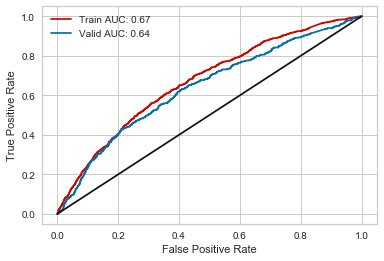

In [180]:
x_train = x_notes_train_tf
y_train = y_notes_train
y_valid = y_notes_valid

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()